In [1]:
import json
import pandas as pd

In [2]:
# read the data
with open('data/YouTube_Data.json', 'r') as f:
    data_dict = json.load(f)

In [3]:
data_dict_for_pandas = {}
for song_name, data in data_dict.items():
    data_dict_for_pandas[song_name] = {}
    for content, data in data_dict[song_name]['items'][0]['contentDetails'].items():
        data_dict_for_pandas[song_name][content] = data
    for statistic, data in data_dict[song_name]['items'][0]['statistics'].items():
        data_dict_for_pandas[song_name][statistic] = data
    if 'snippet' in data_dict[song_name]['items'][0]:
        for snippet, data in data_dict[song_name]['items'][0]['snippet'].items():
            data_dict_for_pandas[song_name][snippet] = data

df = pd.DataFrame.from_dict(data_dict_for_pandas, orient='index')
df

,duration,dimension,definition,caption,licensedContent,contentRating,projection,viewCount,likeCount,favoriteCount,...,title,description,thumbnails,channelTitle,tags,categoryId,liveBroadcastContent,localized,defaultAudioLanguage,defaultLanguage
Hard 2 Love Haystak,PT4M31S,2d,sd,false,False,{},rectangular,19896301,193625,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27 Fall Out Boy,PT3M13S,2d,hd,false,True,{},rectangular,492662,6477,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Devour Shinedown,PT3M49S,2d,sd,false,True,{},rectangular,12883626,75710,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,PT3M44S,2d,hd,false,True,{},rectangular,31936,472,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I Know You Know Esperanza Spalding,PT3M46S,2d,hd,false,True,{},rectangular,590869,12874,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,PT2M22S,2d,hd,false,False,{},rectangular,4025245,34629,0,...,Sleepy Hallow ft. Fivio Foreign - Baddie Betty...,"From the album ""Sleepy For President"". Out now...",{'default': {'url': 'https://i.ytimg.com/vi/Gd...,Sleepy Hallow,NaN,10,none,{'title': 'Sleepy Hallow ft. Fivio Foreign - B...,NaN,en
Love Like That Lauv,PT3M5S,2d,hd,false,True,{},rectangular,2801466,68717,0,...,Lauv - Love Like That [Official Audio],"""""Love Like That"" is available now on ""~how i'...",{'default': {'url': 'https://i.ytimg.com/vi/Bn...,Lauv,"[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10,none,{'title': 'Lauv - Love Like That [Official Aud...,en,NaN
Deep Sleep Recovery Noise Water Sound Natural White Noise,PT2M42S,2d,hd,false,True,{},rectangular,505,1,0,...,Deep Sleep Recovery Natural White Noise - Wate...,Provided to YouTube by AudioSalad\n\nDeep Slee...,{'default': {'url': 'https://i.ytimg.com/vi/MV...,Natural Sound Makers - Topic,"[Natural Sound Makers, Natural Sample Makers, ...",10,none,{'title': 'Deep Sleep Recovery Natural White N...,NaN,NaN
Julia Lauv,PT3M38S,2d,hd,false,True,{},rectangular,5328661,109822,0,...,Lauv - Julia [Official Visualizer],"“Julia” off of Lauv's debut album, ~how i'm fe...",{'default': {'url': 'https://i.ytimg.com/vi/0P...,Lauv,"[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10,none,{'title': 'Lauv - Julia [Official Visualizer]'...,en,NaN


## Data Fixing

In [4]:
import re
import numpy as np
# fix duration format to *seconds*
df['duration'] = df['duration'].apply(lambda s: re.split(r'[HM]', s.strip('PTS'))).apply(lambda lis: sum([int(item) * (60 ** i)  if item else 0 for i, item in enumerate(reversed(lis))])).astype(float)
# fix caption and definition format to boolean
df['caption'] = df['caption'] == 'true'
df['definition'] = df['definition'] == 'hd'
df = df.rename(columns={'definition': 'isHD'})
# fix licensedContent (add nulls in case of "{}") and liveBroadcastContent (add nulls in case of "none")
df['contentRating'] = df['contentRating'].apply(lambda x: np.nan if len(x) == 0 else x)
df['liveBroadcastContent'] = df['liveBroadcastContent'].apply(lambda x: np.nan if x == 'none' else x)
# change all Counts to int
df['viewCount'] = df['viewCount'].astype(float)
df['likeCount'] = df['likeCount'].astype(float)
df['favoriteCount'] = df['favoriteCount'].astype(float)
df['commentCount'] = df['commentCount'].astype(float)
# change all booleans to float
df['caption'] = df['caption'].astype(float)
df['licensedContent'] = df['licensedContent'].astype(float)
df['isHD'] = df['isHD'].astype(float)
# remove uninformative columns
df = df.drop(columns=['channelId', 'channelTitle', 'thumbnails', 'title', 'localized', 'defaultAudioLanguage'])
df

,duration,dimension,isHD,caption,licensedContent,contentRating,projection,viewCount,likeCount,favoriteCount,commentCount,regionRestriction,publishedAt,description,tags,categoryId,liveBroadcastContent,defaultLanguage
Hard 2 Love Haystak,271.0,2d,0.0,0.0,0.0,NaN,rectangular,19896301.0,193625.0,0.0,2153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27 Fall Out Boy,193.0,2d,1.0,0.0,1.0,NaN,rectangular,492662.0,6477.0,0.0,90.0,"{'allowed': ['CA', 'MX', 'US']}",NaN,NaN,NaN,NaN,NaN,NaN
Devour Shinedown,229.0,2d,0.0,0.0,1.0,NaN,rectangular,12883626.0,75710.0,0.0,3888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,224.0,2d,1.0,0.0,1.0,NaN,rectangular,31936.0,472.0,0.0,5.0,"{'allowed': ['CA', 'US']}",NaN,NaN,NaN,NaN,NaN,NaN
I Know You Know Esperanza Spalding,226.0,2d,1.0,0.0,1.0,NaN,rectangular,590869.0,12874.0,0.0,55.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,142.0,2d,1.0,0.0,0.0,NaN,rectangular,4025245.0,34629.0,0.0,578.0,NaN,2020-06-05T04:00:08Z,"From the album ""Sleepy For President"". Out now...",NaN,10,NaN,en
Love Like That Lauv,185.0,2d,1.0,0.0,1.0,NaN,rectangular,2801466.0,68717.0,0.0,2047.0,NaN,2020-05-07T04:00:05Z,"""""Love Like That"" is available now on ""~how i'...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10,NaN,NaN
Deep Sleep Recovery Noise Water Sound Natural White Noise,162.0,2d,1.0,0.0,1.0,NaN,rectangular,505.0,1.0,0.0,0.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",2020-05-02T10:06:38Z,Provided to YouTube by AudioSalad\n\nDeep Slee...,"[Natural Sound Makers, Natural Sample Makers, ...",10,NaN,NaN
Julia Lauv,218.0,2d,1.0,0.0,1.0,NaN,rectangular,5328661.0,109822.0,0.0,2722.0,NaN,2020-03-06T05:01:05Z,"“Julia” off of Lauv's debut album, ~how i'm fe...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10,NaN,NaN


In [5]:
# remove columns with mostly null values
bac_cols = df.columns[df.isnull().mean() > 0.9]
df = df.drop(columns=bac_cols)
print("removed columns: {}".format(bac_cols))
df

removed columns: Index(['contentRating', 'liveBroadcastContent', 'defaultLanguage'], dtype='object')


,duration,dimension,isHD,caption,licensedContent,projection,viewCount,likeCount,favoriteCount,commentCount,regionRestriction,publishedAt,description,tags,categoryId
Hard 2 Love Haystak,271.0,2d,0.0,0.0,0.0,rectangular,19896301.0,193625.0,0.0,2153.0,NaN,NaN,NaN,NaN,NaN
27 Fall Out Boy,193.0,2d,1.0,0.0,1.0,rectangular,492662.0,6477.0,0.0,90.0,"{'allowed': ['CA', 'MX', 'US']}",NaN,NaN,NaN,NaN
Devour Shinedown,229.0,2d,0.0,0.0,1.0,rectangular,12883626.0,75710.0,0.0,3888.0,NaN,NaN,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,224.0,2d,1.0,0.0,1.0,rectangular,31936.0,472.0,0.0,5.0,"{'allowed': ['CA', 'US']}",NaN,NaN,NaN,NaN
I Know You Know Esperanza Spalding,226.0,2d,1.0,0.0,1.0,rectangular,590869.0,12874.0,0.0,55.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,142.0,2d,1.0,0.0,0.0,rectangular,4025245.0,34629.0,0.0,578.0,NaN,2020-06-05T04:00:08Z,"From the album ""Sleepy For President"". Out now...",NaN,10
Love Like That Lauv,185.0,2d,1.0,0.0,1.0,rectangular,2801466.0,68717.0,0.0,2047.0,NaN,2020-05-07T04:00:05Z,"""""Love Like That"" is available now on ""~how i'...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10
Deep Sleep Recovery Noise Water Sound Natural White Noise,162.0,2d,1.0,0.0,1.0,rectangular,505.0,1.0,0.0,0.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",2020-05-02T10:06:38Z,Provided to YouTube by AudioSalad\n\nDeep Slee...,"[Natural Sound Makers, Natural Sample Makers, ...",10
Julia Lauv,218.0,2d,1.0,0.0,1.0,rectangular,5328661.0,109822.0,0.0,2722.0,NaN,2020-03-06T05:01:05Z,"“Julia” off of Lauv's debut album, ~how i'm fe...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10


In [6]:
# remove columns with only 1 value
to_remove = []
for col in df.columns:
    if col in ['regionRestriction', 'contentRating', 'tags']:
        continue
    if df[col].nunique() == 1:
        to_remove.append(col)

df = df.drop(to_remove, axis=1)
print("Removed columns:", to_remove)
df

Removed columns: ['dimension', 'projection', 'favoriteCount']


,duration,isHD,caption,licensedContent,viewCount,likeCount,commentCount,regionRestriction,publishedAt,description,tags,categoryId
Hard 2 Love Haystak,271.0,0.0,0.0,0.0,19896301.0,193625.0,2153.0,NaN,NaN,NaN,NaN,NaN
27 Fall Out Boy,193.0,1.0,0.0,1.0,492662.0,6477.0,90.0,"{'allowed': ['CA', 'MX', 'US']}",NaN,NaN,NaN,NaN
Devour Shinedown,229.0,0.0,0.0,1.0,12883626.0,75710.0,3888.0,NaN,NaN,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,224.0,1.0,0.0,1.0,31936.0,472.0,5.0,"{'allowed': ['CA', 'US']}",NaN,NaN,NaN,NaN
I Know You Know Esperanza Spalding,226.0,1.0,0.0,1.0,590869.0,12874.0,55.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,142.0,1.0,0.0,0.0,4025245.0,34629.0,578.0,NaN,2020-06-05T04:00:08Z,"From the album ""Sleepy For President"". Out now...",NaN,10
Love Like That Lauv,185.0,1.0,0.0,1.0,2801466.0,68717.0,2047.0,NaN,2020-05-07T04:00:05Z,"""""Love Like That"" is available now on ""~how i'...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10
Deep Sleep Recovery Noise Water Sound Natural White Noise,162.0,1.0,0.0,1.0,505.0,1.0,0.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",2020-05-02T10:06:38Z,Provided to YouTube by AudioSalad\n\nDeep Slee...,"[Natural Sound Makers, Natural Sample Makers, ...",10
Julia Lauv,218.0,1.0,0.0,1.0,5328661.0,109822.0,2722.0,NaN,2020-03-06T05:01:05Z,"“Julia” off of Lauv's debut album, ~how i'm fe...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10


## Data Statistics and Exploration

<AxesSubplot:>

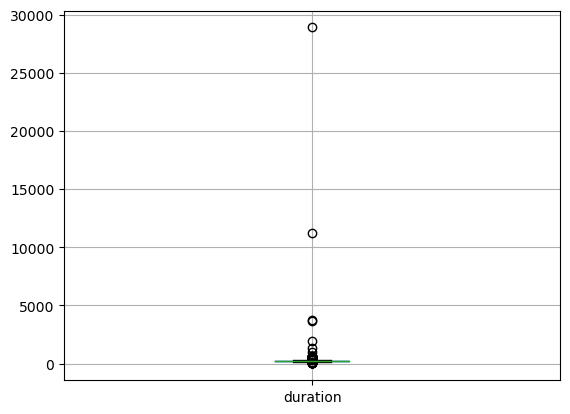

In [7]:
# duration column boxplot
df.boxplot(column=['duration'])

In [8]:
# remove records with duration more than 1000 and less than 60 ("normal song durations")
df = df[(df['duration'] < 1000) & (df['duration'] > 60)]

<AxesSubplot:>

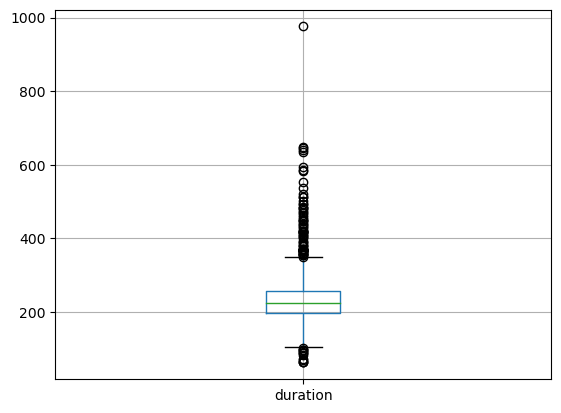

In [9]:
df.boxplot(column=['duration'])

In [10]:
# also, we will check whether the publishing date is affecting the number of views
# we can say that the year of publish must have an effect on the number of views (newer songs are more popular)
# but also, maybe specific months or days of the week have higher exposure
# so we will add columns for year, month, day of week
df['publishDayOfWeek'] = df['publishedAt'].apply(lambda s: pd.to_datetime(s).dayofweek)
df['publishMonth'] = df['publishedAt'].apply(lambda s: pd.to_datetime(s).month)
df['publishYear'] = df['publishedAt'].apply(lambda s: pd.to_datetime(s).year)
df

C:\Users\naorh\AppData\Local\Temp\ipykernel_13188\929002870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['publishDayOfWeek'] = df['publishedAt'].apply(lambda s: pd.to_datetime(s).dayofweek)
C:\Users\naorh\AppData\Local\Temp\ipykernel_13188\929002870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['publishMonth'] = df['publishedAt'].apply(lambda s: pd.to_datetime(s).month)
C:\Users\naorh\AppData\Local\Temp\ipykernel_13188\929002870.py:7: SettingWithCopyWarning: 
A value is trying to be set o

,duration,isHD,caption,licensedContent,viewCount,likeCount,commentCount,regionRestriction,publishedAt,description,tags,categoryId,publishDayOfWeek,publishMonth,publishYear
Hard 2 Love Haystak,271.0,0.0,0.0,0.0,19896301.0,193625.0,2153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27 Fall Out Boy,193.0,1.0,0.0,1.0,492662.0,6477.0,90.0,"{'allowed': ['CA', 'MX', 'US']}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Devour Shinedown,229.0,0.0,0.0,1.0,12883626.0,75710.0,3888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,224.0,1.0,0.0,1.0,31936.0,472.0,5.0,"{'allowed': ['CA', 'US']}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
I Know You Know Esperanza Spalding,226.0,1.0,0.0,1.0,590869.0,12874.0,55.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,142.0,1.0,0.0,0.0,4025245.0,34629.0,578.0,NaN,2020-06-05T04:00:08Z,"From the album ""Sleepy For President"". Out now...",NaN,10,4.0,6.0,2020.0
Love Like That Lauv,185.0,1.0,0.0,1.0,2801466.0,68717.0,2047.0,NaN,2020-05-07T04:00:05Z,"""""Love Like That"" is available now on ""~how i'...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10,3.0,5.0,2020.0
Deep Sleep Recovery Noise Water Sound Natural White Noise,162.0,1.0,0.0,1.0,505.0,1.0,0.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",2020-05-02T10:06:38Z,Provided to YouTube by AudioSalad\n\nDeep Slee...,"[Natural Sound Makers, Natural Sample Makers, ...",10,5.0,5.0,2020.0
Julia Lauv,218.0,1.0,0.0,1.0,5328661.0,109822.0,2722.0,NaN,2020-03-06T05:01:05Z,"“Julia” off of Lauv's debut album, ~how i'm fe...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",10,4.0,3.0,2020.0


<AxesSubplot:xlabel='publishYear'>

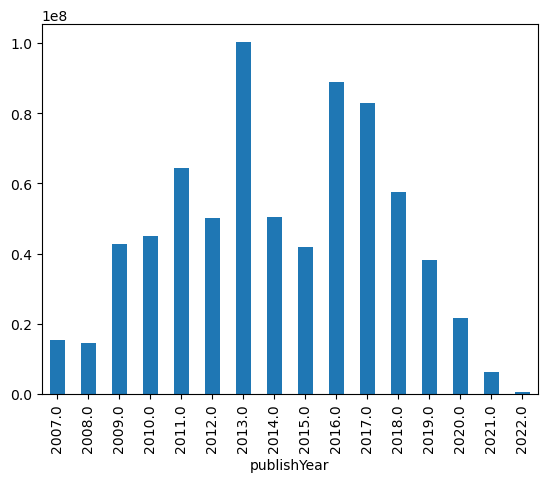

In [11]:
# check the number of views per year
df.groupby('publishYear')['viewCount'].mean().plot.bar()

<AxesSubplot:xlabel='publishMonth'>

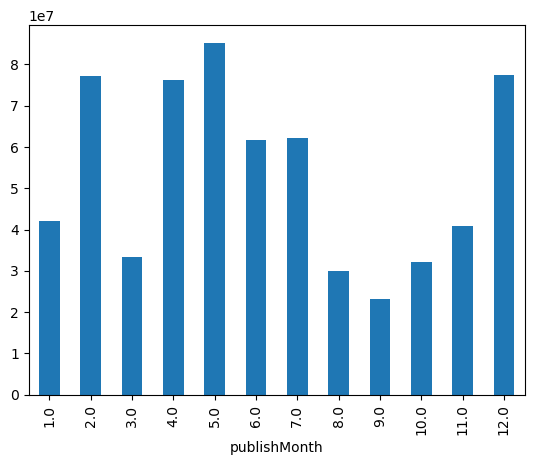

In [12]:
# check the number of views per month
df.groupby('publishMonth')['viewCount'].mean().plot.bar()

<AxesSubplot:xlabel='publishDayOfWeek'>

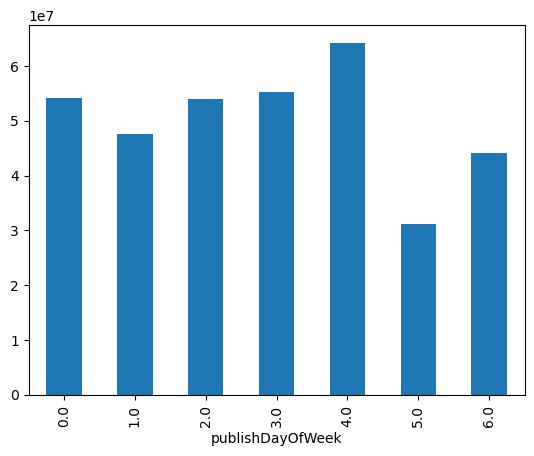

In [13]:
# check the number of views per day of week
df.groupby('publishDayOfWeek')['viewCount'].mean().plot.bar()

In [14]:
# TODO add conclusions about the above whenever we have enough data
df = df.drop(columns=['publishedAt'])

In [15]:
# while all the records we extracted are songs, the categoryId column suggest some on the records are not "Music"
# some records are not labeled as "Music" but according to a sample of those, they are indeed music videos
# this led us to believe some songs were labeled (either accidentally by their uploader or by mistake of YouTube) incorrectly not as "Music"
# however, this mistake might cost in views, so we need to take into consideration this column
# the categoryId "10" is the "Music" category
df['categoryId'] = (df['categoryId'] == '10').astype(float)
df = df.rename(columns={'categoryId': 'isMusicCategory'})
df

,duration,isHD,caption,licensedContent,viewCount,likeCount,commentCount,regionRestriction,description,tags,isMusicCategory,publishDayOfWeek,publishMonth,publishYear
Hard 2 Love Haystak,271.0,0.0,0.0,0.0,19896301.0,193625.0,2153.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
27 Fall Out Boy,193.0,1.0,0.0,1.0,492662.0,6477.0,90.0,"{'allowed': ['CA', 'MX', 'US']}",NaN,NaN,0.0,NaN,NaN,NaN
Devour Shinedown,229.0,0.0,0.0,1.0,12883626.0,75710.0,3888.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,224.0,1.0,0.0,1.0,31936.0,472.0,5.0,"{'allowed': ['CA', 'US']}",NaN,NaN,0.0,NaN,NaN,NaN
I Know You Know Esperanza Spalding,226.0,1.0,0.0,1.0,590869.0,12874.0,55.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,142.0,1.0,0.0,0.0,4025245.0,34629.0,578.0,NaN,"From the album ""Sleepy For President"". Out now...",NaN,1.0,4.0,6.0,2020.0
Love Like That Lauv,185.0,1.0,0.0,1.0,2801466.0,68717.0,2047.0,NaN,"""""Love Like That"" is available now on ""~how i'...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",1.0,3.0,5.0,2020.0
Deep Sleep Recovery Noise Water Sound Natural White Noise,162.0,1.0,0.0,1.0,505.0,1.0,0.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",Provided to YouTube by AudioSalad\n\nDeep Slee...,"[Natural Sound Makers, Natural Sample Makers, ...",1.0,5.0,5.0,2020.0
Julia Lauv,218.0,1.0,0.0,1.0,5328661.0,109822.0,2722.0,NaN,"“Julia” off of Lauv's debut album, ~how i'm fe...","[Lauv, Lauv songs, luv, luav, lavu, lave, lauv...",1.0,4.0,3.0,2020.0


In [16]:
# regionRestriction includes in some records a dictionary with "blocked" and "allowed" keys
# though this sounds like a great feature to tell us whether a video is controversial or not,
# a sample we looked into showed that this column doesn't really represent that, and in fact, no real information is given in this column,
# so we will remove it
df = df.drop(columns=['regionRestriction'])

In [17]:
# looking into the "tags" column, we know the information in "tags" and "description" is self provided by the uploader
# moreover, there are no real repetitions in the "tags" column, so we can't extract useful information from the tags themselves
# however, assuming the act of tagging a video or adding a description increases its exposure, especially if the tags include a frequent search query,
# we can say the viewCount is dependent on the number of tags and the presence of the description
df['tags'] = df['tags'].apply(lambda x: len(x) if not isinstance(x, float) else 0)
df = df.rename(columns={'tags': 'numTags'})
df['description'] = df['description'].apply(lambda x: 1.0 if not isinstance(x, float) else 0.0)
df = df.rename(columns={'description': 'hasDescription'})
df

,duration,isHD,caption,licensedContent,viewCount,likeCount,commentCount,hasDescription,numTags,isMusicCategory,publishDayOfWeek,publishMonth,publishYear
Hard 2 Love Haystak,271.0,0.0,0.0,0.0,19896301.0,193625.0,2153.0,0.0,0,0.0,NaN,NaN,NaN
27 Fall Out Boy,193.0,1.0,0.0,1.0,492662.0,6477.0,90.0,0.0,0,0.0,NaN,NaN,NaN
Devour Shinedown,229.0,0.0,0.0,1.0,12883626.0,75710.0,3888.0,0.0,0,0.0,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,224.0,1.0,0.0,1.0,31936.0,472.0,5.0,0.0,0,0.0,NaN,NaN,NaN
I Know You Know Esperanza Spalding,226.0,1.0,0.0,1.0,590869.0,12874.0,55.0,0.0,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,142.0,1.0,0.0,0.0,4025245.0,34629.0,578.0,1.0,0,1.0,4.0,6.0,2020.0
Love Like That Lauv,185.0,1.0,0.0,1.0,2801466.0,68717.0,2047.0,1.0,16,1.0,3.0,5.0,2020.0
Deep Sleep Recovery Noise Water Sound Natural White Noise,162.0,1.0,0.0,1.0,505.0,1.0,0.0,1.0,5,1.0,5.0,5.0,2020.0
Julia Lauv,218.0,1.0,0.0,1.0,5328661.0,109822.0,2722.0,1.0,14,1.0,4.0,3.0,2020.0


### Create "Popular" (our Y) column

In [18]:
# because popular songs can still have many dislikes or little comments and unpopular songs can have many likes or many comments we decided to discard the likeCount and commentCount columns
df = df.drop(['likeCount', 'commentCount'], axis=1)

# thus, the popular column would be the viewCount column only
df = df.rename(columns={'viewCount': 'popular'})
# we will define a popular song according to the percentiles of the popular column
df['popular'] = df['popular'].apply(lambda x: 1 if x > np.percentile(df['popular'], 75) else 0)
df

,duration,isHD,caption,licensedContent,popular,hasDescription,numTags,isMusicCategory,publishDayOfWeek,publishMonth,publishYear
Hard 2 Love Haystak,271.0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN
27 Fall Out Boy,193.0,1.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
Devour Shinedown,229.0,0.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,224.0,1.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
I Know You Know Esperanza Spalding,226.0,1.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,142.0,1.0,0.0,0.0,0,1.0,0,1.0,4.0,6.0,2020.0
Love Like That Lauv,185.0,1.0,0.0,1.0,0,1.0,16,1.0,3.0,5.0,2020.0
Deep Sleep Recovery Noise Water Sound Natural White Noise,162.0,1.0,0.0,1.0,0,1.0,5,1.0,5.0,5.0,2020.0
Julia Lauv,218.0,1.0,0.0,1.0,0,1.0,14,1.0,4.0,3.0,2020.0


### Research Question:
Does the presence of captions in a music video clip increase its popularity and its chance of being viral?

In [19]:
# this sets our treatment column as "caption"
df = df.rename(columns={'caption': 'treatment'})
df

,duration,isHD,treatment,licensedContent,popular,hasDescription,numTags,isMusicCategory,publishDayOfWeek,publishMonth,publishYear
Hard 2 Love Haystak,271.0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN
27 Fall Out Boy,193.0,1.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
Devour Shinedown,229.0,0.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,224.0,1.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
I Know You Know Esperanza Spalding,226.0,1.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,142.0,1.0,0.0,0.0,0,1.0,0,1.0,4.0,6.0,2020.0
Love Like That Lauv,185.0,1.0,0.0,1.0,0,1.0,16,1.0,3.0,5.0,2020.0
Deep Sleep Recovery Noise Water Sound Natural White Noise,162.0,1.0,0.0,1.0,0,1.0,5,1.0,5.0,5.0,2020.0
Julia Lauv,218.0,1.0,0.0,1.0,0,1.0,14,1.0,4.0,3.0,2020.0


In [20]:
df['treatment'].dropna().mean()

0.0799475753604194

In [21]:
df

,duration,isHD,treatment,licensedContent,popular,hasDescription,numTags,isMusicCategory,publishDayOfWeek,publishMonth,publishYear
Hard 2 Love Haystak,271.0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,NaN,NaN
27 Fall Out Boy,193.0,1.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
Devour Shinedown,229.0,0.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
Chill Or Be Chilled Oli Silk,224.0,1.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
I Know You Know Esperanza Spalding,226.0,1.0,0.0,1.0,0,0.0,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Baddie Betty Boop Sleepy Hallow Fivio Foreign,142.0,1.0,0.0,0.0,0,1.0,0,1.0,4.0,6.0,2020.0
Love Like That Lauv,185.0,1.0,0.0,1.0,0,1.0,16,1.0,3.0,5.0,2020.0
Deep Sleep Recovery Noise Water Sound Natural White Noise,162.0,1.0,0.0,1.0,0,1.0,5,1.0,5.0,5.0,2020.0
Julia Lauv,218.0,1.0,0.0,1.0,0,1.0,14,1.0,4.0,3.0,2020.0


In [22]:
df.to_csv('data/final_data.csv')

In [23]:
# normalize columns

In [113]:
# remove records with duration more than 1000 and less than 60 ("normal song durations")
df = df[(df['duration'] < 1000) & (df['duration'] > 60)]

<AxesSubplot:>

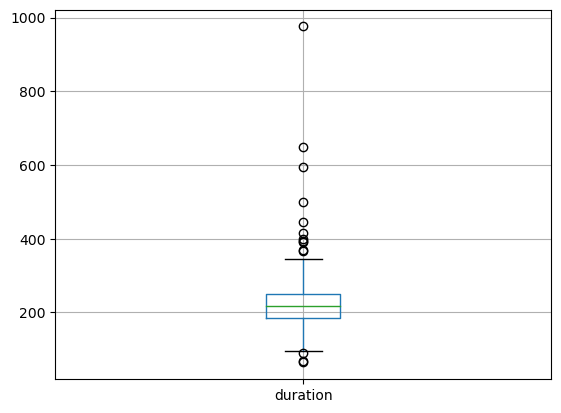

In [114]:
df.boxplot(column=['duration'])

### Create "Popular" column

In [115]:
# because popular songs can still have many dislikes or little comments and unpopular songs can have many likes or many comments we decided to discard the likeCount and commentCount columns
df = df.drop(['likeCount', 'commentCount'], axis=1)

# thus, the popular column would be the viewCount column only
df['popular'] = df['viewCount']

In [116]:
df.tail(200).caption.mean()

0.15

In [117]:
df

,duration,definition,caption,licensedContent,viewCount,regionRestriction,publishedAt,description,tags,categoryId,popular
Hard 2 Love Haystak,271,sd,False,False,19896301.0,NaN,NaN,NaN,NaN,NaN,19896301.0
27 Fall Out Boy,193,hd,False,True,492662.0,"{'allowed': ['CA', 'MX', 'US']}",NaN,NaN,NaN,NaN,492662.0
Devour Shinedown,229,sd,False,True,12883626.0,NaN,NaN,NaN,NaN,NaN,12883626.0
Chill Or Be Chilled Oli Silk,224,hd,False,True,31936.0,"{'allowed': ['CA', 'US']}",NaN,NaN,NaN,NaN,31936.0
I Know You Know Esperanza Spalding,226,hd,False,True,590869.0,"{'allowed': ['AE', 'AR', 'AS', 'AT', 'AU', 'AW...",NaN,NaN,NaN,NaN,590869.0
...,...,...,...,...,...,...,...,...,...,...,...
Never Seen The Rain Tones And I,206,hd,False,True,34345586.0,NaN,2019-08-08T02:26:27Z,3rd single from debut EP 'The Kids Are Coming'...,"[Tones And I, Tones, triple j, jjj, Johnny Run...",10,34345586.0
Soft Rain Pouring Factorial FX,649,hd,False,True,14702582.0,NaN,2017-09-10T02:30:01Z,"Soothing Gentle Rain Sounds (No Thunder, No Mu...","[rain falling, gentle rain, gentle rain sounds...",10,14702582.0
Be Honest (feat. Burna Boy) Jorja Smith Burna Boy,261,hd,False,True,95406813.0,NaN,2019-08-16T11:00:08Z,"Be Honest, out now: http://jorjasmith.com/beho...","[FAMM, Jorja Smith, R&B/Soul, Soul]",10,95406813.0
6's to 9's (feat. Rationale) Big Wild Rationale,207,hd,False,True,1173318.0,NaN,2019-02-01T16:47:46Z,"Taken from the new album 'Superdream', out now...","[Big Wild, Counter Records, Superdream, Ninja ...",10,1173318.0


In [ ]:
# explain how we plan on using the category id (maybe with licensedContent)
# create "controversial" column from regionRestriction (boolean) ???
# create tags count as a feature ???
# normalize columns